In [1]:
import os
os.environ['PRISMATIC_DATA_ROOT'] = ''
os.environ["MUJOCO_GL"] = "egl"
os.environ["PYOPENGL_PLATFORM"] = "egl"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import sys
# sys.path.insert(0, str(Path(__file__).resolve().parents[3]))
# sys.path.insert(0, str(Path().resolve().parents[1]))
sys.path.append("../..")
from libero.libero import benchmark

from experiments.robot.libero.libero_utils import get_libero_env, get_libero_image, quat2axisangle
from experiments.robot.openvla_utils import get_processor, get_vla, get_prismatic_vla
from experiments.robot.robot_utils import get_image_resize_size, set_seed_everywhere

from dataclasses import dataclass
from pathlib import Path
from typing import Union
import numpy as np
import torch

assert torch.cuda.is_available(), "ERROR: CUDA not available!"

os.system("nvidia-smi")


2026-01-10 09:04:58.814917: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-10 09:04:58.817559: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-10 09:04:58.846511: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-01-10 09:04:58.846547: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-01-10 09:04:58.847771: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

Sat Jan 10 09:05:24 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA H100 NVL                On  |   00000000:46:00.0 Off |                    0 |
| N/A   40C    P0             64W /  400W |       0MiB /  95830MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

0

 ### config

In [2]:
@dataclass
class BenchmarkConfig:
    # fmt: off
    # target_checkpoint: Union[str, Path] = "/pub/scratch/aagouzoul/ovla/openvla-mini/ft_experiments_logs/openvla-7b+libero_90_no_noops+b32+lr-0.0005+lora-r32+dropout-0.0--image_aug+libero_90_no_noops+b32+lr-0.0005+lora-r32+dropout-0.0--image_aug"
    target_checkpoint: Union[str, Path] = "/pub/scratch/aagouzoul/ovla/openvla-mini/ft_experiments_logs/openvla-7b+libero_90_no_noops+b32+lr-0.0005+lora-r32+dropout-0.0--image_aug+libero_90_no_noops+b32+lr-0.0005+lora-r32+dropout-0.0--image_aug_step-75000_l1-loss-0.0012_tokacc-0.955"
    draft_checkpoint: Union[str, Path] = "Stanford-ILIAD/minivla-libero90-prismatic"
    hf_token: str = Path("/pub/scratch/aagouzoul/ovla/openvla-mini/.hf_token")
    load_in_8bit: bool = False
    load_in_4bit: bool = False
    center_crop: bool = True
    
    # Speculative decoding parameters
    gamma: int = 7
    temperature: float = 0.0
    relaxed_acceptance_r: int = 0
    
    # Benchmark parameters
    task_suite_name: str = "libero_90"
    task_id: int = 0
    num_iterations: int = 10
    warmup_iterations: int = 5
    seed: int = 42
    
    # fmt: on
    
cfg = BenchmarkConfig()

print("=" * 80)
print("Speculative Decoding Throughput Benchmark")
print("=" * 80)
print(f"Target: {cfg.target_checkpoint}")
print(f"Draft: {cfg.draft_checkpoint}")
print(f"Gamma: {cfg.gamma}")
print(f"Iterations: {cfg.num_iterations}")
print("=" * 80)

set_seed_everywhere(cfg.seed)

class TargetConfig:
    def __init__(self, c):
        self.pretrained_checkpoint = c.target_checkpoint
        self.load_in_8bit = c.load_in_8bit
        self.load_in_4bit = c.load_in_4bit
        self.hf_token = c.hf_token

class DraftConfig:
    def __init__(self, c):
        self.pretrained_checkpoint = c.draft_checkpoint
        self.model_family = "prismatic"
        self.hf_token = c.hf_token
        self.center_crop = c.center_crop



Speculative Decoding Throughput Benchmark
Target: /pub/scratch/aagouzoul/ovla/openvla-mini/ft_experiments_logs/openvla-7b+libero_90_no_noops+b32+lr-0.0005+lora-r32+dropout-0.0--image_aug+libero_90_no_noops+b32+lr-0.0005+lora-r32+dropout-0.0--image_aug_step-75000_l1-loss-0.0012_tokacc-0.955
Draft: Stanford-ILIAD/minivla-libero90-prismatic
Gamma: 7
Iterations: 10


 ### load models



In [3]:
print("\n[1/4] Loading TARGET model (OpenVLA)...")
target_cfg = TargetConfig(cfg)
target_model = get_vla(target_cfg)
target_processor = get_processor(target_cfg)

print("\n[2/4] Loading DRAFT model (MiniVLA)...")
draft_cfg = DraftConfig(cfg)
draft_model = get_prismatic_vla(draft_cfg)

# #########
# from prismatic.models.load import load_vla
# checkpoint = "Stanford-ILIAD/minivla-libero90-prismatic"
# hf_token_path = Path("/pub/scratch/aagouzoul/ovla/openvla-mini/.hf_token")
# # print(f"[*] Initializing Generation Playground with `{cfg.model_family}`")
# hf_token = hf_token_path.read_text().strip() if isinstance(hf_token_path, Path) else os.environ[hf_token_path]
# print(f"Loading VLM from checkpoint: {checkpoint}")
# vla = load_vla(
#     checkpoint,
#     hf_token=hf_token,
#     load_for_training=False,
# )
# for param in vla.parameters():
#     assert param.dtype == torch.float32, f"Loaded VLM parameter not in full precision: {param}"
# # Cast to half precision.
# vla.vision_backbone.to(dtype=vla.vision_backbone.half_precision_dtype)
# vla.llm_backbone.to(dtype=vla.llm_backbone.half_precision_dtype)
# vla.to(dtype=vla.llm_backbone.half_precision_dtype)
# vla.to("cuda")
# draft_model=vla

# try:
#     draft_model.llm_backbone.llm = torch.compile(
#         draft_model.llm_backbone.llm,
#         mode="default",
#         fullgraph=False,
#         dynamic=True,  # Allow dynamic shapes for KV cache
#     )
#     print("  [OK] torch.compile(mode='default') applied to LLM")
# except Exception as e:
#     print(f"  [FAIL] torch.compile failed: {e}")
# ########

# Set unnorm key
unnorm_key_target = cfg.task_suite_name
if unnorm_key_target not in target_model.norm_stats:
    if f"{unnorm_key_target}_no_noops" in target_model.norm_stats:
        unnorm_key_target = f"{unnorm_key_target}_no_noops"
    elif f"{unnorm_key_target.replace('_no_noops', '')}" in target_model.norm_stats:
        unnorm_key_target = f"{unnorm_key_target}"
    else:
        unnorm_key_target = list(target_model.norm_stats.keys())[0]
        
unnorm_key_draft = cfg.task_suite_name
if unnorm_key_draft not in draft_model.norm_stats:
    if f"{unnorm_key_draft}_no_noops" in draft_model.norm_stats:
        unnorm_key_draft = f"{unnorm_key_draft}_no_noops"
    elif f"{unnorm_key_draft.replace('_no_noops', '')}" in draft_model.norm_stats:
        unnorm_key_draft = f"{unnorm_key_draft}"
    else:
        unnorm_key_draft = list(draft_model.norm_stats.keys())[0]

print(f"Using unnorm_keys: {unnorm_key_target} (target), {unnorm_key_draft} (draft)")



[1/4] Loading TARGET model (OpenVLA)...
[*] Instantiating Pretrained VLA model
[*] Loading in BF16 with Flash-Attention Enabled


<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

[SRPPPPPPPPPP] -> .eval() + torch.compile(vla) DISABLED

[2/4] Loading DRAFT model (MiniVLA)...
[*] Initializing Generation Playground with `prismatic`
Loading VLM from checkpoint: Stanford-ILIAD/minivla-libero90-prismatic


01/10 [09:05:30] INFO     | >> [*] Checking HF for `Stanford-ILIAD/minivla-libero90-prismatic`          ]8;id=234053;file:///pub/scratch/aagouzoul/ovla/openvla-mini/experiments/specdec/../../prismatic/models/load.py\load.py]8;;\:]8;id=146316;file:///pub/scratch/aagouzoul/ovla/openvla-mini/experiments/specdec/../../prismatic/models/load.py#163\163]8;;\

01/10 [09:05:31] INFO     | >> [*] Downloading Model `Stanford-ILIAD/minivla-libero90-prismatic` Config ]8;id=571858;file:///pub/scratch/aagouzoul/ovla/openvla-mini/experiments/specdec/../../prismatic/models/load.py\load.py]8;;\:]8;id=91161;file:///pub/scratch/aagouzoul/ovla/openvla-mini/experiments/specdec/../../prismatic/models/load.py#176\176]8;;\
                          & Checkpoint `step-122500-epoch-55-loss=0.0743.pt`                                       

                 INFO     | >> [*] Base vlm: prism-qwen25-extra-dinosiglip-224px+0_5b                   ]8;id=229258;file:///pub/scratch/aagouzoul/ovla/openvla-mini/experiments/specdec/../../prismatic/models/load.py\load.py]8;;\:]8;id=243962;file:///pub/scratch/aagouzoul/ovla/openvla-mini/experiments/specdec/../../prismatic/models/load.py#212\212]8;;\

                 INFO     | >> [*] Found Config =>> Loading & Freezing                                  ]8;id=750800;file:///pub/scratch/aagouzoul/ovla/openvla-mini/experiments/specdec/../../prismatic/models/load.py\load.py]8;;\:]8;id=681453;file:///pub/scratch/aagouzoul/ovla/openvla-mini/experiments/specdec/../../prismatic/models/load.py#221\221]8;;\
                          prism-qwen25-extra-dinosiglip-224px+0_5b with:                                           
                                       Vision Backbone =>> dinosiglip-vit-so-224px                                 
                                       LLM Backbone    =>> qwen25-0_5b-extra                                       
                                       Arch Specifier  =>> no-align+fused-gelu-mlp                                 
                                       Checkpoint Path =>>                                                         
                          `/pub/scratch/aagouzoul/huggingface/hub/models--Stanford-ILIAD--minivla-liber            
                          o90-prismatic/snapshots/4289f87e8e00706e188c7a3a61fc6e7d72ab2564/checkpoints/            
                          step-122500-epoch-55-loss=0.0743.pt`                                                     

                 INFO     | >> [*] Loading Vision Backbone dinosiglip-vit-so-224px                      ]8;id=617889;file:///pub/scratch/aagouzoul/ovla/openvla-mini/experiments/specdec/../../prismatic/models/load.py\load.py]8;;\:]8;id=291704;file:///pub/scratch/aagouzoul/ovla/openvla-mini/experiments/specdec/../../prismatic/models/load.py#236\236]8;;\

01/10 [09:05:36] INFO     | >> Loading pretrained weights from Hugging Face hub                     ]8;id=732052;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_builder.py\_builder.py]8;;\:]8;id=443143;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_builder.py#186\186]8;;\
                          (timm/vit_large_patch14_reg4_dinov2.lvd142m)                                             

                 INFO     | >>  Safe alternative available for 'pytorch_model.bin' (as                  ]8;id=107175;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_hub.py\_hub.py]8;;\:]8;id=97251;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_hub.py#180\180]8;;\
                          'model.safetensors'). Loading weights using safetensors.                                 

                 INFO     | >> Resized position embedding: (37, 37) to (16, 16).                    ]8;id=277370;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/layers/pos_embed.py\pos_embed.py]8;;\:]8;id=846335;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/layers/pos_embed.py#55\55]8;;\

01/10 [09:05:43] INFO     | >> Loading pretrained weights from Hugging Face hub                     ]8;id=130889;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_builder.py\_builder.py]8;;\:]8;id=967096;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_builder.py#186\186]8;;\
                          (('timm/ViT-SO400M-14-SigLIP', 'open_clip_pytorch_model.bin'))                           

                 INFO     | >>  Safe alternative available for 'open_clip_pytorch_model.bin' (as        ]8;id=869693;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_hub.py\_hub.py]8;;\:]8;id=659176;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_hub.py#180\180]8;;\
                          'open_clip_model.safetensors'). Loading weights using safetensors.                       

                 INFO     | >> [*] Loading Pretrained LLM qwen25-0_5b-extra via HF Transformers         ]8;id=201629;file:///pub/scratch/aagouzoul/ovla/openvla-mini/experiments/specdec/../../prismatic/models/load.py\load.py]8;;\:]8;id=738797;file:///pub/scratch/aagouzoul/ovla/openvla-mini/experiments/specdec/../../prismatic/models/load.py#244\244]8;;\

                 INFO     | >>     |=> Building empty qwen2.5 LLM from `Qwen/Qwen2.5-0.5B`          ]8;id=83667;file:///pub/scratch/aagouzoul/ovla/openvla-mini/experiments/specdec/../../prismatic/models/backbones/llm/base_llm.py\base_llm.py]8;;\:]8;id=896865;file:///pub/scratch/aagouzoul/ovla/openvla-mini/experiments/specdec/../../prismatic/models/backbones/llm/base_llm.py#134\134]8;;\

01/10 [09:05:50] INFO     | >>     |=> Loading qwen2.5 (Fast) Tokenizer via the AutoTokenizer API   ]8;id=475435;file:///pub/scratch/aagouzoul/ovla/openvla-mini/experiments/specdec/../../prismatic/models/backbones/llm/base_llm.py\base_llm.py]8;;\:]8;id=666563;file:///pub/scratch/aagouzoul/ovla/openvla-mini/experiments/specdec/../../prismatic/models/backbones/llm/base_llm.py#156\156]8;;\

Added 256 extra tokens.


                 INFO     | >> [*] Loading VLA prism-qwen25-extra-dinosiglip-224px+0_5b from Checkpoint ]8;id=219684;file:///pub/scratch/aagouzoul/ovla/openvla-mini/experiments/specdec/../../prismatic/models/load.py\load.py]8;;\:]8;id=702729;file:///pub/scratch/aagouzoul/ovla/openvla-mini/experiments/specdec/../../prismatic/models/load.py#257\257]8;;\

[SRPPPPPPPPPP] -> .eval() + torch.compile(prismatic) DISABLED
Using unnorm_keys: libero_90_no_noops (target), libero_90 (draft)


In [4]:
# Load LIBERO task and get observation
print(f"\n[4/4] Loading LIBERO task: {cfg.task_suite_name} (task {cfg.task_id})...")
benchmark_dict = benchmark.get_benchmark_dict()
task_suite = benchmark_dict[cfg.task_suite_name]()
task = task_suite.get_task(cfg.task_id)
env, task_description = get_libero_env(task, "openvla", resolution=224)

initial_states = task_suite.get_task_init_states(cfg.task_id)
env.reset()
obs = env.set_init_state(initial_states[0])

# Prepare observation
img = get_libero_image(obs, 224)
observation = {
    "full_image": img,
    "state": np.concatenate(
        (obs["robot0_eef_pos"], quat2axisangle(obs["robot0_eef_quat"]), obs["robot0_gripper_qpos"])
    ),
}

print(f"Task: {task_description}")
print(f"Image shape: {img.shape}")


print("\033[38;2;255;165;0m[SRP] -> \033[0m", f"call params: get_vla_action(target_model..., target_processor..., cfg.target_checkpoint={cfg.target_checkpoint}, observation=..., task_description={task_description}, unnorm_key={unnorm_key_target}, center_crop={cfg.center_crop})")
print("\033[38;2;255;165;0m[SRP] -> \033[0m", f"call params: get_prismatic_vla_action(draft_model..., processor=None, cfg.draft_checkpoint={cfg.draft_checkpoint}, observation..., task_description={task_description}, unnorm_key={unnorm_key_draft}, center_crop={cfg.center_crop})")

def run_target_inference():
    from experiments.robot.openvla_utils import get_vla_action
    return get_vla_action(
        target_model,
        target_processor,
        str(cfg.target_checkpoint),
        observation,
        task_description,
        unnorm_key_target,
        center_crop=cfg.center_crop,
    )

# def run_draft_inference():
#     from experiments.robot.openvla_utils import get_prismatic_vla_action    
#     return get_prismatic_vla_action(
#         draft_model,
#         None,
#         str(cfg.draft_checkpoint),
#         observation,
#         task_description,
#         unnorm_key_draft,
#         center_crop=cfg.center_crop,
#     )
from experiments.specdec.minivla_fastpath import MiniVLAFastPath
draft_fast = MiniVLAFastPath(
    model=draft_model,
    instruction=task_description,
    unnorm_key=unnorm_key_draft,
    center_crop=cfg.center_crop,  
    compile_llm=True,            
    compile_mode="default",
    compile_vision=True,   
    compile_mode_vision="reduce-overhead",
)
def run_draft_inference():
    return draft_fast.predict_action_from_np(observation["full_image"])


def timed_cuda(fn):
    """Time a function using CUDA events for accurate GPU timing."""
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)
    start.record()
    result = fn()
    end.record()
    torch.cuda.synchronize()
    return result, start.elapsed_time(end) / 1000  # Convert to seconds

print(f"\nRunning warmup ({cfg.warmup_iterations} iterations each)...")

print("  Warming up TARGET...")
for _ in range(cfg.warmup_iterations):
    run_target_inference()
    torch.cuda.synchronize()

print("  Warming up DRAFT...")
for _ in range(cfg.warmup_iterations):
    run_draft_inference()
    torch.cuda.synchronize()
    
# Benchmark TARGET
print(f"\nBenchmarking TARGET ({cfg.num_iterations} iterations)...")
target_times = []
for i in range(cfg.num_iterations):
    result, dt = timed_cuda(run_target_inference)
    target_times.append(dt)
    if (i + 1) % 5 == 0:
        print(f"  Progress: {i+1}/{cfg.num_iterations}, last: {dt*1000:.1f}ms")

# Benchmark DRAFT
print(f"\nBenchmarking DRAFT ({cfg.num_iterations} iterations)...")
draft_times = []
for i in range(cfg.num_iterations):
    result, dt = timed_cuda(run_draft_inference)
    draft_times.append(dt)
    if (i + 1) % 5 == 0:
        print(f"  Progress: {i+1}/{cfg.num_iterations}, last: {dt*1000:.1f}ms")



[4/4] Loading LIBERO task: libero_90 (task 0)...
Task: close the top drawer of the cabinet
Image shape: (224, 224, 3)
[SRP] ->  call params: get_vla_action(target_model..., target_processor..., cfg.target_checkpoint=/pub/scratch/aagouzoul/ovla/openvla-mini/ft_experiments_logs/openvla-7b+libero_90_no_noops+b32+lr-0.0005+lora-r32+dropout-0.0--image_aug+libero_90_no_noops+b32+lr-0.0005+lora-r32+dropout-0.0--image_aug_step-75000_l1-loss-0.0012_tokacc-0.955, observation=..., task_description=close the top drawer of the cabinet, unnorm_key=libero_90_no_noops, center_crop=True)
[SRP] ->  call params: get_prismatic_vla_action(draft_model..., processor=None, cfg.draft_checkpoint=Stanford-ILIAD/minivla-libero90-prismatic, observation..., task_description=close the top drawer of the cabinet, unnorm_key=libero_90, center_crop=True)

Running warmup (5 iterations each)...
  Warming up TARGET...
  Warming up DRAFT...

Benchmarking TARGET (10 iterations)...
  Progress: 5/10, last: 181.2ms
  Progress:

In [5]:
# %load vla_speculative_decoding.py
import math
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple, Union
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from transformers.cache_utils import DynamicCache

# ============================================================================
# Cache utilities for KV cache pruning
# ============================================================================
def prune_cache(
    cache: Union[Tuple[Tuple[torch.Tensor, torch.Tensor]], DynamicCache, None],
    num_tokens_to_discard: int,
) -> Union[Tuple[Tuple[torch.Tensor, torch.Tensor]], DynamicCache, None]:
    """Prune the KV cache by removing tokens from the end."""
    if cache is None or num_tokens_to_discard <= 0:
        return cache
    
    if isinstance(cache, DynamicCache):
        for layer in range(len(cache)):
            cache.key_cache[layer] = cache.key_cache[layer][:, :, :-num_tokens_to_discard, :]
            cache.value_cache[layer] = cache.value_cache[layer][:, :, :-num_tokens_to_discard, :]
        cache._seen_tokens -= num_tokens_to_discard
        return cache
    
    elif isinstance(cache, tuple):
        new_cache = []
        for layer_cache in cache:
            if layer_cache is None:
                new_cache.append(None)
                continue
            layer = []
            for tensor in layer_cache:
                new_tensor = tensor[:, :, :-num_tokens_to_discard, :]
                layer.append(new_tensor)
            new_cache.append(tuple(layer))
        return tuple(new_cache)
    
    else:
        raise ValueError(f"Unsupported cache type: {type(cache)}")

# ============================================================================
# Image preprocessing utilities
# ============================================================================
def apply_center_crop(im: np.ndarray, t_h: int, t_w: int) -> np.ndarray:
    """Center crop an image to target dimensions."""
    assert im.shape[-3] >= t_h and im.shape[-2] >= t_w
    crop_h = int((im.shape[-3] - t_h) / 2)
    crop_w = int((im.shape[-2] - t_w) / 2)
    return im[..., crop_h : crop_h + t_h, crop_w : crop_w + t_w, :]

def prepare_image(full_image: Union[np.ndarray, List[np.ndarray]], center_crop: bool = False) -> Image.Image:
    """Convert numpy image to PIL Image with optional center crop."""
    if isinstance(full_image, list):
        full_image = full_image[0]
    
    image = Image.fromarray(full_image).convert("RGB")
    
    if center_crop:
        temp_image = np.array(image)
        crop_scale = 0.9
        sqrt_crop_scale = math.sqrt(crop_scale)
        temp_image_cropped = apply_center_crop(
            temp_image,
            t_h=int(sqrt_crop_scale * temp_image.shape[0]),
            t_w=int(sqrt_crop_scale * temp_image.shape[1]),
        )
        image = Image.fromarray(temp_image_cropped)
        image = image.resize((224, 224), Image.Resampling.BILINEAR)
    
    return image

# ============================================================================
# Speculative decoding core implementation
# ============================================================================
@dataclass
class SpeculativeDecodingStats:
    """Statistics from speculative decoding run."""
    total_tokens_generated: int = 0
    total_draft_tokens_proposed: int = 0
    total_draft_tokens_accepted: int = 0
    total_target_forward_passes: int = 0
    total_draft_forward_passes: int = 0
    
    @property
    def acceptance_rate(self) -> float:
        if self.total_draft_tokens_proposed == 0:
            return 0.0
        return self.total_draft_tokens_accepted / self.total_draft_tokens_proposed
    
    @property
    def tokens_per_target_forward(self) -> float:
        if self.total_target_forward_passes == 0:
            return 0.0
        return self.total_tokens_generated / self.total_target_forward_passes

def max_fn(x: torch.Tensor) -> torch.Tensor:
    """Normalize max(0, x) to create a valid probability distribution."""
    x_max = torch.where(x > 0, x, torch.zeros_like(x))
    x_max_sum = torch.sum(x_max, dim=-1, keepdim=True)
    # Avoid division by zero
    return x_max / (x_max_sum + 1e-10)


In [6]:

# VLASpeculativeDecoderBatchedLM: Uses language model directly for batched verification
# Key insight from SpecVLA: After multimodal prefill, call language_model directly
# with inputs_embeds and cached KV, bypassing the restrictive multimodal forward.


class VLASpeculativeDecoderBatchedLM:
    """
    Speculative decoding for VLA models with EFFICIENT batched verification.
    
    Key difference from VLASpeculativeDecoderDDDRKVB:
    - Initial prefill: Full multimodal forward (processes image once)
    - Verification: Calls language_model DIRECTLY with embeddings + cached KV
    
    Why 10 forward passes for 7 tokens?
    1 prefill
    4 rejection rounds * (1 verify + 1 advance) = 8
    1 acceptance round * 1 verify = 1
    Total = 10
    The problem is: after each rejection, we do 2 target forward passes:
    Batched verification (wasted - we only needed position 0's logits)
    Advance with corrected token (to get logits for next round)
    - Early rejection: Skips batched verification if first draft token will definitely be rejected
    
    This bypasses the Prismatic multimodal forward restriction that only allows
    single-token inference with KV cache, enabling true batched verification.
    """
    
    def __init__(
        self,
        target_model,
        draft_model,
        target_processor=None,
        gamma: int = 4,
        temperature: float = 0.0,
        n_action_bins: int = 256,
        relaxed_acceptance_r: int = 0,
        verbose: bool = False,
    ):
        self.verbose = verbose
        
        self.target = target_model
        self.draft = draft_model
        self.target_processor = target_processor
        self.gamma = gamma
        self.temperature = temperature
        self.n_action_bins = n_action_bins
        self.relaxed_acceptance_r = relaxed_acceptance_r
        
        self.device = next(target_model.parameters()).device
        self.stats = SpeculativeDecodingStats()
        self._setup_token_mapping()
        
    
    def _setup_token_mapping(self):
        """Setup token mapping between draft and target vocabularies."""
        # Target model
        if hasattr(self.target, 'language_model') and hasattr(self.target.language_model, 'model'):
            self.target_logit_dim = self.target.language_model.model.embed_tokens.weight.shape[0]
        elif hasattr(self.target, 'get_output_embeddings'):
            self.target_logit_dim = self.target.get_output_embeddings().weight.shape[0]
        else:
            self.target_logit_dim = self.target.config.vocab_size
        
        if hasattr(self.target, 'vocab_size'):
            self.target_vocab_size = self.target.vocab_size
        elif hasattr(self.target, 'config') and hasattr(self.target.config, 'vocab_size'):
            self.target_vocab_size = self.target.config.vocab_size
        else:
            self.target_vocab_size = self.target_logit_dim
        
        # Draft model
        if hasattr(self.draft, 'llm_backbone'):
            draft_tokenizer = self.draft.llm_backbone.tokenizer
            self.draft_vocab_size = len(draft_tokenizer) if hasattr(draft_tokenizer, '__len__') else draft_tokenizer.vocab_size
            if hasattr(self.draft.llm_backbone, 'llm') and hasattr(self.draft.llm_backbone.llm, 'lm_head'):
                self.draft_logit_dim = self.draft.llm_backbone.llm.lm_head.weight.shape[0]
            else:
                self.draft_logit_dim = self.draft_vocab_size
        else:
            self.draft_vocab_size = self.draft.config.vocab_size
            self.draft_logit_dim = self.draft_vocab_size
        
        self.vocab_compatible = (self.target_logit_dim == self.draft_logit_dim)
        
        # Action token ranges
        self.target_action_start = self.target_vocab_size - self.n_action_bins
        self.draft_action_start = self.draft_vocab_size - self.n_action_bins
        
        if self.verbose: print("\033[38;2;255;165;0m[BatchedLM] -> \033[0m", f"Target vocab_size: {self.target_vocab_size}, logit_dim: {self.target_logit_dim}")
        if self.verbose: print("\033[38;2;255;165;0m[BatchedLM] -> \033[0m", f"Draft vocab_size: {self.draft_vocab_size}, logit_dim: {self.draft_logit_dim}")
        if self.verbose: print("\033[38;2;255;165;0m[BatchedLM] -> \033[0m", f"Vocabularies compatible: {self.vocab_compatible}")
        
    def _draft_token_to_target(self, draft_token_id: int) -> int:
        if self.vocab_compatible:
            return draft_token_id
        if draft_token_id >= self.draft_action_start:
            action_bin = draft_token_id - self.draft_action_start
            return self.target_action_start + action_bin
        return min(draft_token_id, self.target_vocab_size - 1)
    
    def _target_token_to_draft(self, target_token_id: int) -> int:
        if self.vocab_compatible:
            return target_token_id
        if target_token_id >= self.target_action_start:
            action_bin = target_token_id - self.target_action_start
            return self.draft_action_start + action_bin
        return min(target_token_id, self.draft_vocab_size - 1)

    def _remap_logits_draft_to_target(self, draft_logits: torch.Tensor, target_logit_dim: int = None) -> torch.Tensor:
        if self.vocab_compatible:
            return draft_logits
        if target_logit_dim is None:
            target_logit_dim = self.target_logit_dim
        target_logits = torch.full(
            (draft_logits.shape[0], target_logit_dim), float('-inf'),
            device=draft_logits.device, dtype=draft_logits.dtype
        )
        draft_action_logits = draft_logits[:, self.draft_action_start:self.draft_vocab_size]
        target_logits[:, self.target_action_start:self.target_vocab_size] = draft_action_logits
        return target_logits
    
    def _get_action_bin_from_draft_token(self, draft_token_id: int) -> int:
        if draft_token_id >= self.draft_action_start:
            return draft_token_id - self.draft_action_start
        return -1
    
    def _get_action_bin_from_target_token(self, target_token_id: int) -> int:
        if target_token_id >= self.target_action_start:
            return target_token_id - self.target_action_start
        return -1
    
    def _get_continuous_action_from_bin(self, bin_idx: int) -> float:
        if 0 <= bin_idx < len(self.target.bin_centers):
            return self.target.bin_centers[bin_idx]
        return float('nan')
    
    def reset_stats(self):
        self.stats = SpeculativeDecodingStats()
        
    def _sample_token(self, logits: torch.Tensor) -> torch.Tensor:
        if self.temperature <= 0:
            return torch.argmax(logits, dim=-1, keepdim=True)
        probs = F.softmax(logits / self.temperature, dim=-1)
        return torch.multinomial(probs.squeeze(0), num_samples=1).unsqueeze(0)
    
    def _get_probs(self, logits: torch.Tensor) -> torch.Tensor:
        if self.temperature <= 0:
            return F.softmax(logits / 0.01, dim=-1)
        return F.softmax(logits / self.temperature, dim=-1)

    def _prepare_target_inputs(self, image: Image.Image, instruction: str) -> Dict[str, torch.Tensor]:
        prompt = f"In: What action should the robot take to {instruction.lower()}?\nOut:"
        inputs = self.target_processor(prompt, image).to(self.device, dtype=torch.bfloat16)
        # Add special token 29871 if not present
        if not torch.all(inputs["input_ids"][:, -1] == 29871):
            inputs["input_ids"] = torch.cat(
                (inputs["input_ids"], torch.tensor([[29871]], device=self.device)), dim=1
            )
            if "attention_mask" in inputs:
                inputs["attention_mask"] = torch.cat(
                    (inputs["attention_mask"], torch.ones((1, 1), device=self.device, dtype=inputs["attention_mask"].dtype)), dim=1
                )
        return inputs
    
    def _prepare_draft_inputs(self, image: Image.Image, instruction: str) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        prompt_builder = self.draft.get_prompt_builder()
        prompt_builder.add_turn(role="human", message=f"What action should the robot take to {instruction.lower()}?")
        prompt_text = prompt_builder.get_prompt()
        
        tokenizer = self.draft.llm_backbone.tokenizer
        input_ids = tokenizer(prompt_text, truncation=True, return_tensors="pt").input_ids.to(self.device)
        
        from transformers import LlamaTokenizerFast
        if isinstance(tokenizer, LlamaTokenizerFast):
            if not torch.all(input_ids[:, -1] == 29871):
                input_ids = torch.cat((input_ids, torch.tensor([[29871]], device=self.device)), dim=1)
        
        attention_mask = torch.ones_like(input_ids)
        
        image_transform = self.draft.vision_backbone.get_image_transform()
        pixel_values = image_transform(image)
        if isinstance(pixel_values, torch.Tensor):
            pixel_values = pixel_values[None, ...].to(self.device)
        elif isinstance(pixel_values, dict):
            pixel_values = {k: v[None, ...].to(self.device) for k, v in pixel_values.items()}
        
        return input_ids, attention_mask, pixel_values
    
    @torch.inference_mode()
    def predict_action_speculative(
        self,
        image: Image.Image,
        instruction: str,
        unnorm_key_target: str,
    ) -> Tuple[np.ndarray, SpeculativeDecodingStats]:
        """
        Generate action using speculative decoding with efficient batched verification.
        
        The key innovation: After multimodal prefill, we call the language model DIRECTLY
        with embeddings and cached KV, bypassing the restrictive multimodal forward.
        """
        call_stats = SpeculativeDecodingStats()
        action_dim = self.target.get_action_dim(unnorm_key_target)
        
        # Prepare inputs
        target_inputs = self._prepare_target_inputs(image, instruction)
        draft_input_ids, draft_attention_mask, draft_pixel_values = self._prepare_draft_inputs(image, instruction)
        autocast_dtype = self.draft.llm_backbone.half_precision_dtype
        
        generated_token_ids = []
        
        with torch.autocast("cuda", dtype=torch.bfloat16, enabled=True):
            # === PHASE 1: Multimodal Prefill (processes image ONCE) ===
            if self.verbose: print("\033[38;2;100;200;255m[BatchedLM] Phase 1: Multimodal Prefill\033[0m")
            
            # Target prefill - get KV cache with image embeddings
            target_out = self.target(
                **target_inputs,
                past_key_values=None,
                use_cache=True,
                output_hidden_states=True,
            )
            target_cache = target_out.past_key_values
            target_logits = target_out.logits[:, -1, :]
            call_stats.total_target_forward_passes += 1
            
            # Get the sequence length after multimodal prefill (includes patch embeddings)
            kv_seq_len = target_cache[0][0].shape[2]  # [batch, heads, seq_len, head_dim]
            if self.verbose: print(f"  Target KV cache seq_len after prefill: {kv_seq_len}")
            
            # Draft prefill
            with torch.autocast("cuda", dtype=autocast_dtype, enabled=self.draft.enable_mixed_precision_training):
                draft_out = self.draft(
                    input_ids=draft_input_ids,
                    attention_mask=draft_attention_mask,
                    pixel_values=draft_pixel_values,
                    past_key_values=None,
                    use_cache=True,
                )
            draft_cache = draft_out.past_key_values
            draft_logits = draft_out.logits[:, -1, :]
            call_stats.total_draft_forward_passes += 1
            
            # Get embed_tokens function for converting tokens to embeddings
            embed_tokens = self.target.language_model.model.embed_tokens
            
            # === PHASE 2: Speculative Decoding Loop ===
            if self.verbose: print("\033[38;2;100;200;255m[BatchedLM] Phase 2: Speculative Decoding\033[0m")
            
            while len(generated_token_ids) < action_dim:
                gamma = min(self.gamma, action_dim - len(generated_token_ids))
                
                # Generate FIRST draft token to check for early rejection
                draft_probs_first = self._get_probs(draft_logits)
                draft_token_first = self._sample_token(draft_logits)
                draft_token_first_target = self._draft_token_to_target(draft_token_first.item())
                
                # EARLY REJECTION CHECK: Can we determine rejection without batched verification?
                # For greedy decoding (temperature=0), we can check bin distance directly
                target_preferred = torch.argmax(target_logits, dim=-1).item()
                first_draft_bin = self._get_action_bin_from_target_token(draft_token_first_target)
                target_preferred_bin = self._get_action_bin_from_target_token(target_preferred)
                first_bin_distance = abs(first_draft_bin - target_preferred_bin) if first_draft_bin >= 0 and target_preferred_bin >= 0 else float('inf')
                
                # Check if first token would be accepted (relaxed or standard greedy)
                p_target_first = self._get_probs(target_logits)[0, draft_token_first_target].item()
                p_draft_first = draft_probs_first[0, draft_token_first_target].item()
                acceptance_prob_first = min(1.0, p_target_first / p_draft_first) if p_draft_first > 0 else (1.0 if p_target_first > 0 else 0.0)
                
                first_relaxed_accept = (self.relaxed_acceptance_r > 0 and first_bin_distance <= self.relaxed_acceptance_r)
                first_standard_accept = (torch.rand(1).item() < acceptance_prob_first)
                first_will_accept = first_relaxed_accept or first_standard_accept
                
                if not first_will_accept:
                    # EARLY REJECTION: Skip batched verification entirely!
                    # We already have target_logits, so just sample corrected token from it
                    call_stats.total_draft_tokens_proposed += 1
                    
                    # Sample corrected token from target's distribution
                    draft_probs_first_remapped = self._get_probs(self._remap_logits_draft_to_target(draft_probs_first, target_logits.shape[-1]))
                    target_probs = self._get_probs(target_logits)
                    adjusted_probs = max_fn(target_probs - draft_probs_first_remapped)
                    if adjusted_probs.sum() > 0:
                        corrected_token = torch.multinomial(adjusted_probs, num_samples=1).item()
                    else:
                        corrected_token = target_preferred  # Use argmax
                    
                    corrected_bin = self._get_action_bin_from_target_token(corrected_token)
                    if self.verbose: print(f"\033[38;2;255;200;100m[EARLY REJECT]\033[0m draft_bin={first_draft_bin}, target_bin={target_preferred_bin}, corrected_bin={corrected_bin} (saved verify pass!)")
                    
                    generated_token_ids.append(corrected_token)
                    call_stats.total_tokens_generated += 1
                    
                    # Advance target with corrected token (1 forward pass - this is necessary)
                    if len(generated_token_ids) < action_dim:
                        corrected_embeds = embed_tokens(torch.tensor([[corrected_token]], device=self.device))
                        corrected_pos = torch.tensor([[target_cache[0][0].shape[2]]], device=self.device)
                        lm_step = self.target.language_model(
                            inputs_embeds=corrected_embeds,
                            past_key_values=target_cache,
                            position_ids=corrected_pos,
                            use_cache=True,
                        )
                        target_cache = lm_step.past_key_values
                        target_logits = lm_step.logits[:, -1, :]
                        call_stats.total_target_forward_passes += 1
                        
                        # Update draft with corrected token (in draft vocab)
                        corrected_draft = self._target_token_to_draft(corrected_token)
                        with torch.autocast("cuda", dtype=autocast_dtype, enabled=self.draft.enable_mixed_precision_training):
                            draft_step = self.draft(
                                input_ids=torch.tensor([[corrected_draft]], device=self.device),
                                past_key_values=draft_cache,
                                use_cache=True,
                            )
                        draft_cache = draft_step.past_key_values
                        draft_logits = draft_step.logits[:, -1, :]
                        call_stats.total_draft_forward_passes += 1
                    
                    continue  # Next iteration
                
                # First token looks good - generate remaining draft tokens
                draft_tokens = [draft_token_first]
                draft_probs_list = [draft_probs_first]
                current_draft_cache = draft_cache
                
                # Advance draft with first token
                with torch.autocast("cuda", dtype=autocast_dtype, enabled=self.draft.enable_mixed_precision_training):
                    draft_step = self.draft(
                        input_ids=draft_token_first.to(self.device),
                        past_key_values=current_draft_cache,
                        use_cache=True,
                    )
                current_draft_cache = draft_step.past_key_values
                current_draft_logits = draft_step.logits[:, -1, :]
                call_stats.total_draft_forward_passes += 1
                
                # Generate remaining gamma-1 draft tokens
                for _ in range(gamma - 1):
                    draft_probs = self._get_probs(current_draft_logits)
                    draft_token = self._sample_token(current_draft_logits)
                    draft_tokens.append(draft_token)
                    draft_probs_list.append(draft_probs)
                    
                    with torch.autocast("cuda", dtype=autocast_dtype, enabled=self.draft.enable_mixed_precision_training):
                        draft_step = self.draft(
                            input_ids=draft_token.to(self.device),
                            past_key_values=current_draft_cache,
                            use_cache=True,
                        )
                    current_draft_cache = draft_step.past_key_values
                    current_draft_logits = draft_step.logits[:, -1, :]
                    call_stats.total_draft_forward_passes += 1
                
                call_stats.total_draft_tokens_proposed += gamma
                
                # Map draft tokens to target vocab
                draft_token_ids_target = [self._draft_token_to_target(dt.item()) for dt in draft_tokens]
                
                # === BATCHED VERIFICATION via Language Model ===
                draft_tokens_tensor = torch.tensor([draft_token_ids_target], device=self.device)
                draft_embeds = embed_tokens(draft_tokens_tensor)
                
                current_kv_len = target_cache[0][0].shape[2]
                position_ids = torch.arange(current_kv_len, current_kv_len + gamma, device=self.device).unsqueeze(0)
                
                lm_out = self.target.language_model(
                    inputs_embeds=draft_embeds,
                    past_key_values=target_cache,
                    position_ids=position_ids,
                    use_cache=True,
                )
                call_stats.total_target_forward_passes += 1
                
                target_logits_batch = lm_out.logits
                new_target_cache = lm_out.past_key_values
                
                # eval_logits[i] evaluates draft_token[i]
                eval_logits = torch.cat([target_logits.unsqueeze(1), target_logits_batch[:, :-1, :]], dim=1)
                target_probs_batch = self._get_probs(eval_logits)
                last_target_logits = target_logits_batch[:, -1, :]
                
                if self.verbose: print(f"\033[38;2;100;200;255m[BatchedLM] Batched verification: 1 forward pass for {gamma} tokens\033[0m")
                
                actual_target_logit_dim = target_probs_batch.shape[-1]
                draft_probs_remapped = [self._get_probs(self._remap_logits_draft_to_target(dp, actual_target_logit_dim)) for dp in draft_probs_list]
                
                # Rejection sampling (first token already checked, but re-verify for consistency)
                n_accepted = 0
                
                for i in range(gamma):
                    draft_token_id_target = draft_token_ids_target[i]
                    draft_prob_remapped = draft_probs_remapped[i]
                    target_prob = target_probs_batch[:, i, :]
                    
                    p_target = target_prob[0, draft_token_id_target].item()
                    p_draft = draft_prob_remapped[0, draft_token_id_target].item()
                    
                    target_preferred = torch.argmax(target_prob, dim=-1).item()
                    draft_bin = self._get_action_bin_from_target_token(draft_token_id_target)
                    target_bin = self._get_action_bin_from_target_token(target_preferred)
                    
                    bin_distance = abs(draft_bin - target_bin) if draft_bin >= 0 and target_bin >= 0 else float('inf')
                    relaxed_accept = (self.relaxed_acceptance_r > 0 and bin_distance <= self.relaxed_acceptance_r)
                    
                    acceptance_prob = min(1.0, p_target / p_draft) if p_draft > 0 else (1.0 if p_target > 0 else 0.0)
                    standard_accept = (torch.rand(1).item() < acceptance_prob)
                    
                    if relaxed_accept or standard_accept:
                        generated_token_ids.append(draft_token_id_target)
                        n_accepted += 1
                        call_stats.total_tokens_generated += 1
                        call_stats.total_draft_tokens_accepted += 1
                        
                        accept_reason = "RELAXED" if relaxed_accept and not standard_accept else "STANDARD"
                        if self.verbose: print(f"\033[38;2;0;255;0m[ACCEPT-{accept_reason}]\033[0m [{i}] bin={draft_bin}, target_bin={target_bin}, dist={bin_distance}")
                        
                        if len(generated_token_ids) >= action_dim:
                            break
                    else:
                        adjusted_probs = max_fn(target_prob - draft_prob_remapped)
                        corrected_token = torch.multinomial(adjusted_probs, num_samples=1).item() if adjusted_probs.sum() > 0 else target_preferred
                        
                        corrected_bin = self._get_action_bin_from_target_token(corrected_token)
                        if self.verbose: print(f"\033[38;2;255;100;100m[REJECT]\033[0m [{i}] draft_bin={draft_bin}, target_bin={target_bin}, corrected_bin={corrected_bin}")
                        
                        generated_token_ids.append(corrected_token)
                        call_stats.total_tokens_generated += 1
                        break
                
                # Update caches based on acceptance
                if n_accepted == gamma and len(generated_token_ids) < action_dim:
                    # All accepted - sample bonus token
                    target_cache = new_target_cache
                    target_logits = last_target_logits
                    
                    bonus_token = self._sample_token(target_logits).item()
                    bonus_bin = self._get_action_bin_from_target_token(bonus_token)
                    if self.verbose: print(f"\033[38;2;0;255;0m[ALL ACCEPTED]\033[0m Bonus token: bin={bonus_bin}")
                    generated_token_ids.append(bonus_token)
                    call_stats.total_tokens_generated += 1
                    
                    # Advance caches
                    bonus_embeds = embed_tokens(torch.tensor([[bonus_token]], device=self.device))
                    bonus_pos = torch.tensor([[target_cache[0][0].shape[2]]], device=self.device)
                    lm_step = self.target.language_model(
                        inputs_embeds=bonus_embeds,
                        past_key_values=target_cache,
                        position_ids=bonus_pos,
                        use_cache=True,
                    )
                    target_cache = lm_step.past_key_values
                    target_logits = lm_step.logits[:, -1, :]
                    call_stats.total_target_forward_passes += 1
                    
                    draft_cache = current_draft_cache
                    bonus_draft = self._target_token_to_draft(bonus_token)
                    with torch.autocast("cuda", dtype=autocast_dtype, enabled=self.draft.enable_mixed_precision_training):
                        draft_step = self.draft(
                            input_ids=torch.tensor([[bonus_draft]], device=self.device),
                            past_key_values=draft_cache,
                            use_cache=True,
                        )
                    draft_cache = draft_step.past_key_values
                    draft_logits = draft_step.logits[:, -1, :]
                    call_stats.total_draft_forward_passes += 1
                    
                elif len(generated_token_ids) < action_dim:
                    # Some rejected - update caches
                    if n_accepted > 0:
                        tokens_to_discard = gamma - n_accepted
                        target_cache = prune_cache(new_target_cache, tokens_to_discard) if tokens_to_discard > 0 else new_target_cache
                    
                    last_token = generated_token_ids[-1]
                    last_embeds = embed_tokens(torch.tensor([[last_token]], device=self.device))
                    last_pos = torch.tensor([[target_cache[0][0].shape[2]]], device=self.device)
                    
                    lm_step = self.target.language_model(
                        inputs_embeds=last_embeds,
                        past_key_values=target_cache,
                        position_ids=last_pos,
                        use_cache=True,
                    )
                    target_cache = lm_step.past_key_values
                    target_logits = lm_step.logits[:, -1, :]
                    call_stats.total_target_forward_passes += 1
                    
                    draft_cache = prune_cache(current_draft_cache, gamma - n_accepted)
                    last_draft = self._target_token_to_draft(last_token)
                    with torch.autocast("cuda", dtype=autocast_dtype, enabled=self.draft.enable_mixed_precision_training):
                        draft_step = self.draft(
                            input_ids=torch.tensor([[last_draft]], device=self.device),
                            past_key_values=draft_cache,
                            use_cache=True,
                        )
                    draft_cache = draft_step.past_key_values
                    draft_logits = draft_step.logits[:, -1, :]
                    call_stats.total_draft_forward_passes += 1
            
            if self.verbose: print(f"\033[38;2;255;165;0m[BatchedLM] -> \033[0m Stats: {call_stats}")
        
        # Decode tokens to actions
        predicted_action_token_ids = np.array(generated_token_ids[:action_dim], dtype=np.int64)
        vocab_size = self.target.vocab_size
        discretized_actions = vocab_size - predicted_action_token_ids
        discretized_actions = np.clip(discretized_actions - 1, a_min=0, a_max=self.target.bin_centers.shape[0] - 1)
        normalized_actions = self.target.bin_centers[discretized_actions]
        
        # Un-normalize
        action_norm_stats = self.target.get_action_stats(unnorm_key_target)
        mask = action_norm_stats.get("mask", np.ones_like(action_norm_stats["q01"], dtype=bool))
        action_high, action_low = np.array(action_norm_stats["q99"]), np.array(action_norm_stats["q01"])
        actions = np.where(
            mask,
            0.5 * (normalized_actions + 1) * (action_high - action_low) + action_low,
            normalized_actions,
        )
        
        # Update global stats
        self.stats.total_tokens_generated += call_stats.total_tokens_generated
        self.stats.total_draft_tokens_proposed += call_stats.total_draft_tokens_proposed
        self.stats.total_draft_tokens_accepted += call_stats.total_draft_tokens_accepted
        self.stats.total_target_forward_passes += call_stats.total_target_forward_passes
        self.stats.total_draft_forward_passes += call_stats.total_draft_forward_passes
        
        return actions, call_stats


In [7]:
# from experiments.specdec.vla_speculative_decoding import (
#     VLASpeculativeDecoder,
#     prepare_image,
# )
# FIXME: when temperature=0.0, current implementation uses 0.01...
cfg.gamma = 6 # gamma 0 is broken (qkv error)

# Create speculative decoder
print("\n[3/4] Creating speculative decoder...")

specdec_decoder = VLASpeculativeDecoderBatchedLM(
    target_model=target_model,
    draft_model=draft_model,
    target_processor=target_processor,
    gamma=cfg.gamma,
    temperature=cfg.temperature,
    relaxed_acceptance_r=cfg.relaxed_acceptance_r,  # Relaxed acceptance with r=7 bins
)

# Prepare PIL image for specdec
pil_image = prepare_image(observation["full_image"], center_crop=cfg.center_crop)

def run_specdec_inference():
    action, stats = specdec_decoder.predict_action_speculative(
        pil_image, task_description, unnorm_key_target
    )
    return action, stats

print("  Warming up SPECDEC...")
for _ in range(cfg.warmup_iterations):
    run_specdec_inference()
    torch.cuda.synchronize()

# Benchmark SPECDEC
print(f"\nBenchmarking SPECDEC ({cfg.num_iterations} iterations)...")
specdec_times = []
specdec_acceptance_rates = []
specdec_tokens_per_forward = []
specdec_decoder.reset_stats()

for i in range(cfg.num_iterations):
    (action, stats), dt = timed_cuda(run_specdec_inference)
    specdec_times.append(dt)
    specdec_acceptance_rates.append(stats.acceptance_rate)
    specdec_tokens_per_forward.append(stats.tokens_per_target_forward)
    if (i + 1) % 10 == 0:
        print(f"  Progress: {i+1}/{cfg.num_iterations}, last: {dt*1000:.1f}ms, "
                f"accept: {stats.acceptance_rate:.2%}")

try:
    env.close()
except:
    pass

def compute_statistics():
    # Compute statistics
    target_mean = np.mean(target_times)
    target_std = np.std(target_times)
    draft_mean = np.mean(draft_times)
    draft_std = np.std(draft_times)
    specdec_mean = np.mean(specdec_times)
    specdec_std = np.std(specdec_times)

    # Print results
    print("\n" + "=" * 80)
    print("RESULTS")
    print("=" * 80)

    print(f"\nTARGET:")
    print(f"  Mean time: {target_mean*1000:.2f} ± {target_std*1000:.2f} ms")
    print(f"  Throughput: {1/target_mean:.2f} Hz")

    print(f"\nDRAFT:")
    print(f"  Mean time: {draft_mean*1000:.2f} ± {draft_std*1000:.2f} ms")
    print(f"  Throughput: {1/draft_mean:.2f} Hz")

    print(f"\nSPECULATIVE DECODING (gamma={cfg.gamma}, r={cfg.relaxed_acceptance_r}):")
    print(f"  Mean time: {specdec_mean*1000:.2f} ± {specdec_std*1000:.2f} ms")
    print(f"  Throughput: {1/specdec_mean:.2f} Hz")
    print(f"  Acceptance rate: {np.mean(specdec_acceptance_rates):.2%} ± {np.std(specdec_acceptance_rates):.2%}")
    print(f"  Tokens/target forward: {np.mean(specdec_tokens_per_forward):.2f}")

    print(f"\nSPEEDUPS:")
    print(f"  SpecDec vs Target: {target_mean/specdec_mean:.2f}x")
    print(f"  Draft vs Target: {target_mean/draft_mean:.2f}x")

    # Overall stats from decoder
    global_stats = specdec_decoder.stats
    print(f"\nOVERALL SPECDEC STATS:")
    print(f"  Total tokens generated: {global_stats.total_tokens_generated}")
    print(f"  Total draft tokens proposed: {global_stats.total_draft_tokens_proposed}")
    print(f"  Total draft tokens accepted: {global_stats.total_draft_tokens_accepted}")
    print(f"  Overall acceptance rate: {global_stats.acceptance_rate:.2%}")
    print(f"  Total target forward passes: {global_stats.total_target_forward_passes}")
    print(f"  Total draft forward passes: {global_stats.total_draft_forward_passes}")

    print("=" * 80)

compute_statistics()



[3/4] Creating speculative decoder...
  Warming up SPECDEC...

Benchmarking SPECDEC (10 iterations)...
  Progress: 10/10, last: 390.8ms, accept: 25.00%

RESULTS

TARGET:
  Mean time: 182.46 ± 2.33 ms
  Throughput: 5.48 Hz

DRAFT:
  Mean time: 71.84 ± 0.60 ms
  Throughput: 13.92 Hz

SPECULATIVE DECODING (gamma=6, r=0):
  Mean time: 397.37 ± 16.11 ms
  Throughput: 2.52 Hz
  Acceptance rate: 25.00% ± 0.00%
  Tokens/target forward: 0.88

SPEEDUPS:
  SpecDec vs Target: 0.46x
  Draft vs Target: 2.54x

OVERALL SPECDEC STATS:
  Total tokens generated: 70
  Total draft tokens proposed: 80
  Total draft tokens accepted: 20
  Overall acceptance rate: 25.00%
  Total target forward passes: 80
  Total draft forward passes: 100


In [8]:
import matplotlib.pyplot as plt
import numpy as np

target_mean_baseline = np.mean(target_times)

# === Plot 1: Acceptance Rate vs Relaxation Threshold ===
# You'll need to run benchmarks with different relaxation thresholds
# For demonstration, I'll show how to structure the code

relaxation_thresholds = [0, 5, 10, 15, 20, 25, 30, 45]
acceptance_rates = []
speedups_r = []

# Run benchmarks for each threshold
for r in relaxation_thresholds:
    print(f"Benchmarking with relaxation threshold r={r}")
    
    # Create new decoder with this threshold
    specdec_decoder_r = VLASpeculativeDecoderBatchedLM(
        target_model=target_model,
        draft_model=draft_model,
        target_processor=target_processor,
        gamma=cfg.gamma,
        temperature=cfg.temperature,
        relaxed_acceptance_r=r,
    )
    
    # Warmup
    for _ in range(cfg.warmup_iterations):
        specdec_decoder_r.predict_action_speculative(
            pil_image, task_description, unnorm_key_target
        )
        torch.cuda.synchronize()
    
    # Benchmark
    times_r = []
    specdec_decoder_r.reset_stats()
    for i in range(cfg.num_iterations):
        start = torch.cuda.Event(enable_timing=True)  
        end = torch.cuda.Event(enable_timing=True)    
        start.record()                                
        action, stats = specdec_decoder_r.predict_action_speculative(
            pil_image, task_description, unnorm_key_target
        )
        end.record()                                  
        torch.cuda.synchronize()
        times_r.append(start.elapsed_time(end) / 1000)
    
    # Store acceptance rate and speedup
    acceptance_rates.append(specdec_decoder_r.stats.acceptance_rate)
    mean_time_r = np.mean(times_r)                    
    speedup_r = target_mean_baseline / mean_time_r
    speedups_r.append(speedup_r)                      
    print(f"  Acceptance rate: {specdec_decoder_r.stats.acceptance_rate:.2%}, Speedup: {speedup_r:.2f}x")  # MODIFY THIS LINE

# === Plot 2: Speedup vs Gamma ===
gamma_values = list(range(0, 8))  # 0 to 7
speedups = []
acceptance_rates_gamma = []

for gamma in gamma_values:
    print(f"\nBenchmarking with gamma={gamma}")
    
    if gamma == 0:
        # No speculation - just use target model
        speedup = 1.0
        acceptance_rate = 0.0
    else:
        # Create decoder with this gamma
        specdec_decoder_gamma = VLASpeculativeDecoderBatchedLM(
            target_model=target_model,
            draft_model=draft_model,
            target_processor=target_processor,
            gamma=gamma,
            temperature=cfg.temperature,
            relaxed_acceptance_r=cfg.relaxed_acceptance_r,  # Use your preferred threshold
        )
        
        # Warmup
        for _ in range(cfg.warmup_iterations):
            specdec_decoder_gamma.predict_action_speculative(
                pil_image, task_description, unnorm_key_target
            )
            torch.cuda.synchronize()
        
        # Benchmark
        times_gamma = []
        specdec_decoder_gamma.reset_stats()
        for i in range(cfg.num_iterations):
            start = torch.cuda.Event(enable_timing=True)
            end = torch.cuda.Event(enable_timing=True)
            start.record()
            action, stats = specdec_decoder_gamma.predict_action_speculative(
                pil_image, task_description, unnorm_key_target
            )
            end.record()
            torch.cuda.synchronize()
            times_gamma.append(start.elapsed_time(end) / 1000)
        
        mean_time = np.mean(times_gamma)
        speedup = target_mean_baseline / mean_time
        acceptance_rate = specdec_decoder_gamma.stats.acceptance_rate
    
    speedups.append(speedup)
    acceptance_rates_gamma.append(acceptance_rate)
    print(f"  Speedup: {speedup:.2f}x, Acceptance rate: {acceptance_rate:.2%}")


Benchmarking with relaxation threshold r=0
  Acceptance rate: 25.00%, Speedup: 0.46x
Benchmarking with relaxation threshold r=5
  Acceptance rate: 35.29%, Speedup: 0.50x
Benchmarking with relaxation threshold r=10
  Acceptance rate: 38.89%, Speedup: 0.51x
Benchmarking with relaxation threshold r=15
  Acceptance rate: 38.89%, Speedup: 0.51x
Benchmarking with relaxation threshold r=20
  Acceptance rate: 44.44%, Speedup: 0.53x
Benchmarking with relaxation threshold r=25
  Acceptance rate: 66.67%, Speedup: 0.57x
Benchmarking with relaxation threshold r=30
  Acceptance rate: 66.67%, Speedup: 0.57x
Benchmarking with relaxation threshold r=45
  Acceptance rate: 100.00%, Speedup: 0.74x

Benchmarking with gamma=0
  Speedup: 1.00x, Acceptance rate: 0.00%

Benchmarking with gamma=1
  Speedup: 0.51x, Acceptance rate: 33.33%

Benchmarking with gamma=2
  Speedup: 0.49x, Acceptance rate: 28.57%

Benchmarking with gamma=3
  Speedup: 0.47x, Acceptance rate: 25.00%

Benchmarking with gamma=4
  Speedup: 

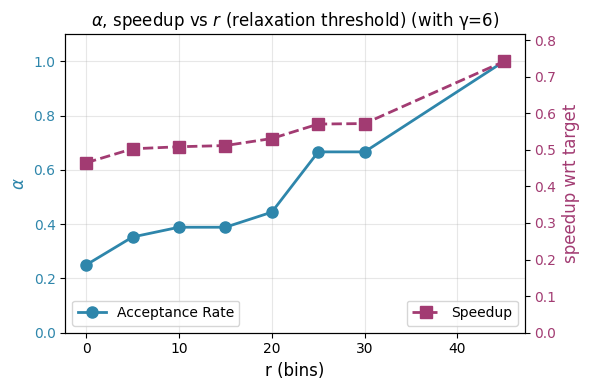

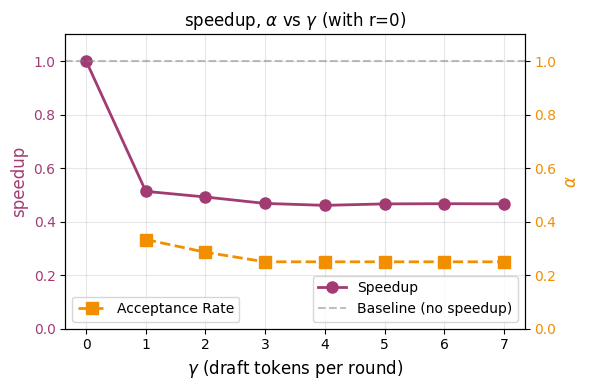

Plots saved:
  - acceptance_rate_vs_threshold.png
  - speedup_vs_gamma.png


In [9]:
# # Plot acceptance rate vs relaxation threshold
# plt.figure(figsize=(6, 4))
# plt.plot(relaxation_thresholds, [r * 100 for r in acceptance_rates], 
#          marker='o', linewidth=2, markersize=8, color='#2E86AB')
# plt.xlabel('r (bins)', fontsize=12)
# plt.ylabel(r'$\alpha$', fontsize=12)
# plt.title(r'$\alpha$ vs $r$ (relaxation threshold)', fontsize=12)
# plt.grid(True, alpha=0.3)
# plt.ylim(0, 105)
# plt.tight_layout()
# plt.savefig('acceptance_rate_vs_threshold.png', dpi=300, bbox_inches='tight')
# plt.show()

# Plot acceptance rate vs relaxation threshold
fig, ax1 = plt.subplots(figsize=(6, 4))

color1 = '#2E86AB'
ax1.set_xlabel('r (bins)', fontsize=12)
ax1.set_ylabel(r'$\alpha$', fontsize=12, color=color1)
ax1.plot(relaxation_thresholds, acceptance_rates, 
         marker='o', linewidth=2, markersize=8, color=color1, label='Acceptance Rate')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, max(acceptance_rates) * 1.1)
ax1.legend(loc='lower left')

# Add speedup on secondary y-axis
ax2 = ax1.twinx()
color2 = '#A23B72'
ax2.set_ylabel('speedup wrt target', fontsize=12, color=color2)
ax2.plot(relaxation_thresholds, speedups_r, marker='s', linewidth=2, markersize=8, 
         color=color2, linestyle='--', label='Speedup')
ax2.tick_params(axis='y', labelcolor=color2)
ax2.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5)
ax2.set_ylim(0.0, max(speedups_r) * 1.1)
ax2.legend(loc='lower right')

plt.title(r'$\alpha$, speedup vs $r$ (relaxation threshold)' + f' (with γ={cfg.gamma})', fontsize=12)  # MODIFY
fig.tight_layout()  # MODIFY
plt.savefig('acceptance_rate_vs_threshold.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot speedup vs gamma
fig, ax1 = plt.subplots(figsize=(6, 4))

color1 = '#A23B72'
ax1.set_xlabel(r'$\gamma$ (draft tokens per round)', fontsize=12)
ax1.set_ylabel('speedup', fontsize=12, color=color1)
ax1.plot(gamma_values, speedups, marker='o', linewidth=2, markersize=8, 
         color=color1, label='Speedup')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5, label='Baseline (no speedup)')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(gamma_values)
ax1.set_ylim(0.0, max(speedups) * 1.1)
ax1.legend(loc='lower right')

# acceptance rate on secondary y-axis
ax2 = ax1.twinx()
color2 = '#F18F01'
ax2.set_ylabel(r'$\alpha$', fontsize=12, color=color2)
ax2.plot(gamma_values[1:], acceptance_rates_gamma[1:], 
         marker='s', linewidth=2, markersize=8, color=color2, 
         linestyle='--', label='Acceptance Rate')
ax2.tick_params(axis='y', labelcolor=color2)
# ax2.set_ylim(0.0, max(acceptance_rates_gamma[1:]) * 1.1)
ax2.set_ylim(0.0, 1.1)
ax2.legend(loc='lower left')
plt.title(r'speedup, $\alpha$ vs $\gamma$' + f' (with r={cfg.relaxed_acceptance_r})', fontsize=12)
fig.tight_layout()
plt.savefig('speedup_vs_gamma.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plots saved:")
print("  - acceptance_rate_vs_threshold.png")
print("  - speedup_vs_gamma.png")


Benchmarking with gamma=0
Benchmarking with gamma=1
Benchmarking with gamma=2
Benchmarking with gamma=3
Benchmarking with gamma=4
Benchmarking with gamma=5
Benchmarking with gamma=6
Benchmarking with gamma=7


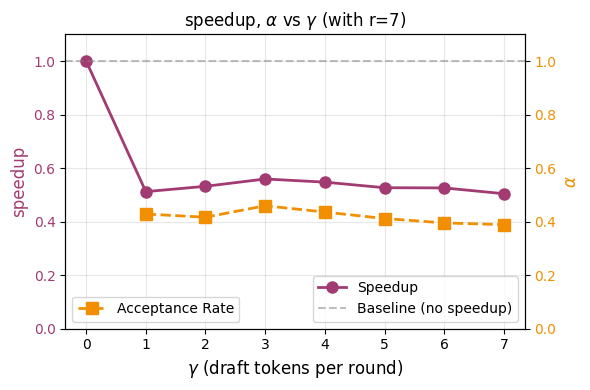

In [10]:
# === Plot 2222: Speedup vs Gamma ===
gamma_values = list(range(0, 8))  # 0 to 7
speedups = []
acceptance_rates_gamma = []
RRRR=7
for gamma in gamma_values:
    print(f"Benchmarking with gamma={gamma}")
    
    if gamma == 0:
        # No speculation - just use target model
        speedup = 1.0
        acceptance_rate = 0.0
    else:
        # Create decoder with this gamma
        specdec_decoder_gamma = VLASpeculativeDecoderBatchedLM(
            target_model=target_model,
            draft_model=draft_model,
            target_processor=target_processor,
            gamma=gamma,
            temperature=cfg.temperature,
            relaxed_acceptance_r=RRRR,
        )
        
        # Warmup
        for _ in range(cfg.warmup_iterations):
            specdec_decoder_gamma.predict_action_speculative(
                pil_image, task_description, unnorm_key_target
            )
            torch.cuda.synchronize()
        
        # Benchmark
        times_gamma = []
        specdec_decoder_gamma.reset_stats()
        for i in range(cfg.num_iterations):
            start = torch.cuda.Event(enable_timing=True)
            end = torch.cuda.Event(enable_timing=True)
            start.record()
            action, stats = specdec_decoder_gamma.predict_action_speculative(
                pil_image, task_description, unnorm_key_target
            )
            end.record()
            torch.cuda.synchronize()
            times_gamma.append(start.elapsed_time(end) / 1000)
        
        mean_time = np.mean(times_gamma)
        speedup = target_mean_baseline / mean_time
        acceptance_rate = specdec_decoder_gamma.stats.acceptance_rate
    
    speedups.append(speedup)
    acceptance_rates_gamma.append(acceptance_rate)

# Plot speedup vs gamma
fig, ax1 = plt.subplots(figsize=(6, 4))

color1 = '#A23B72'
ax1.set_xlabel(r'$\gamma$ (draft tokens per round)', fontsize=12)
ax1.set_ylabel('speedup', fontsize=12, color=color1)
ax1.plot(gamma_values, speedups, marker='o', linewidth=2, markersize=8, 
         color=color1, label='Speedup')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5, label='Baseline (no speedup)')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(gamma_values)
ax1.set_ylim(0.0, max(speedups) * 1.1)
ax1.legend(loc='lower right')

# acceptance rate on secondary y-axis
ax2 = ax1.twinx()
color2 = '#F18F01'
ax2.set_ylabel(r'$\alpha$', fontsize=12, color=color2)
ax2.plot(gamma_values[1:], acceptance_rates_gamma[1:], 
         marker='s', linewidth=2, markersize=8, color=color2, 
         linestyle='--', label='Acceptance Rate')
ax2.tick_params(axis='y', labelcolor=color2)
ax2.set_ylim(0, 1.1)
ax2.legend(loc='lower left')
plt.title(r'speedup, $\alpha$ vs $\gamma$' + f' (with r={RRRR})', fontsize=12)
fig.tight_layout()
plt.savefig('speedup_vs_gamma.png', dpi=300, bbox_inches='tight')
plt.show()


Benchmarking with gamma=0
Benchmarking with gamma=1
Benchmarking with gamma=2
Benchmarking with gamma=3
Benchmarking with gamma=4
Benchmarking with gamma=5
Benchmarking with gamma=6
Benchmarking with gamma=7


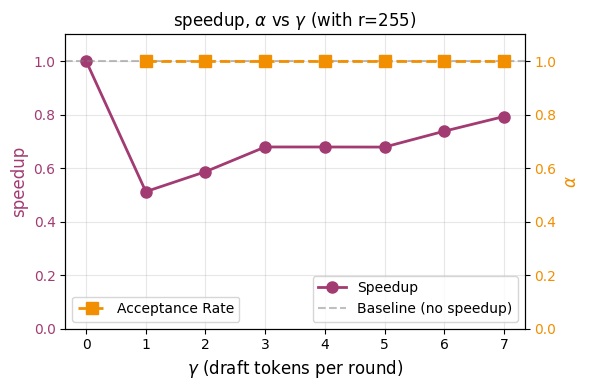

In [11]:
# === Plot 2222: Speedup vs Gamma ===
gamma_values = list(range(0, 8))  # 0 to 7
speedups = []
acceptance_rates_gamma = []
RRRR=255
for gamma in gamma_values:
    print(f"Benchmarking with gamma={gamma}")
    
    if gamma == 0:
        # No speculation - just use target model
        speedup = 1.0
        acceptance_rate = 0.0
    else:
        # Create decoder with this gamma
        specdec_decoder_gamma = VLASpeculativeDecoderBatchedLM(
            target_model=target_model,
            draft_model=draft_model,
            target_processor=target_processor,
            gamma=gamma,
            temperature=cfg.temperature,
            relaxed_acceptance_r=RRRR,
        )
        
        # Warmup
        for _ in range(cfg.warmup_iterations):
            specdec_decoder_gamma.predict_action_speculative(
                pil_image, task_description, unnorm_key_target
            )
            torch.cuda.synchronize()
        
        # Benchmark
        times_gamma = []
        specdec_decoder_gamma.reset_stats()
        for i in range(cfg.num_iterations):
            start = torch.cuda.Event(enable_timing=True)
            end = torch.cuda.Event(enable_timing=True)
            start.record()
            action, stats = specdec_decoder_gamma.predict_action_speculative(
                pil_image, task_description, unnorm_key_target
            )
            end.record()
            torch.cuda.synchronize()
            times_gamma.append(start.elapsed_time(end) / 1000)
        
        mean_time = np.mean(times_gamma)
        speedup = target_mean_baseline / mean_time
        acceptance_rate = specdec_decoder_gamma.stats.acceptance_rate
    
    speedups.append(speedup)
    acceptance_rates_gamma.append(acceptance_rate)

# Plot speedup vs gamma
fig, ax1 = plt.subplots(figsize=(6, 4))

color1 = '#A23B72'
ax1.set_xlabel(r'$\gamma$ (draft tokens per round)', fontsize=12)
ax1.set_ylabel('speedup', fontsize=12, color=color1)
ax1.plot(gamma_values, speedups, marker='o', linewidth=2, markersize=8, 
         color=color1, label='Speedup')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5, label='Baseline (no speedup)')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(gamma_values)
ax1.set_ylim(0.0, max(speedups) * 1.1)
ax1.legend(loc='lower right')

# acceptance rate on secondary y-axis
ax2 = ax1.twinx()
color2 = '#F18F01'
ax2.set_ylabel(r'$\alpha$', fontsize=12, color=color2)
ax2.plot(gamma_values[1:], acceptance_rates_gamma[1:], 
         marker='s', linewidth=2, markersize=8, color=color2, 
         linestyle='--', label='Acceptance Rate')
ax2.tick_params(axis='y', labelcolor=color2)
ax2.set_ylim(0, max(acceptance_rates_gamma[1:]) * 1.1)
ax2.legend(loc='lower left')
plt.title(r'speedup, $\alpha$ vs $\gamma$' + f' (with r={RRRR})', fontsize=12)
fig.tight_layout()
plt.savefig('speedup_vs_gamma.png', dpi=300, bbox_inches='tight')
plt.show()


